In [5]:
import pandas as pd
from snorkel.labeling import labeling_function,PandasLFApplier, LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter, LabelModel

In [6]:
import csv
names = ["qid", 'query', "did", 'url']
df = pd.read_csv("../data/input/orcas_small.tsv", sep='\t', names=names, quoting=csv.QUOTE_NONE)

In [7]:
df['query'] = df['query'].astype(str)

In [8]:
INSTRUMENTAL = 1
FACTUAL = 0
ABSTAIN = -1

In [9]:
df_train = df.sample(frac=0.5)
df_test = df[~df.index.isin(df_train.index)]

In [10]:
print(df_train.shape)
print(df_test.shape)
print(df.shape)

(50000, 4)
(50000, 4)
(100000, 4)


In [91]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="query", doc_field="doc", memoize=True)

In [92]:
@labeling_function(pre=[spacy])
def lf_is_verb(x):
    if(x.doc[0].pos_ == "VERB" and x.doc[0].text == x.doc[0].lemma_):
        return INSTRUMENTAL
    else:
        return ABSTAIN

@labeling_function(pre=[spacy])
def lf_is_verb(x):
    if any([token.pos_ == "VERB" and token.text == token.lemma_ for token in x.doc]):
        return INSTRUMENTAL
    else:
        return ABSTAIN

In [93]:
@labeling_function()
def lf_keyword_lookup(x):
  keywords = ["why","what","when","who","where","how"]
  return FACTUAL if any(word in x.query.lower() and "how to" not in x.query.lower() for word in keywords) else ABSTAIN

In [94]:
@labeling_function()
def lf_question_words(x):
  keywords = ["is","can","do","does"]
  return FACTUAL if any(x.query.lower().startswith(word) for word in keywords) else ABSTAIN

In [95]:
@labeling_function()
def lf_facts_lookup(x):
  keywords = ["facts","statistics","quantity","quantities"]
  return FACTUAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [96]:
@labeling_function()
def lf_finance_lookup(x):
  keywords = ["average","sum","cost","amount","salary","salaries","pay"]
  return FACTUAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [97]:
@labeling_function()
def lf_phone(x):
  keywords = ["number","phone","code","zip"]
  return FACTUAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [98]:
@labeling_function()
def lf_definition(x):
  keywords = ["define","definition","meaning"]
  return FACTUAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [99]:
@labeling_function()
def lf_howto(x):
  keywords = ["how to"]
  return INSTRUMENTAL if any(word in x.query.lower() for word in keywords) else ABSTAIN

In [100]:
import re
@labeling_function()
def lf_digit(x):
    return FACTUAL if re.search(r"\d", x.query, flags=re.I) else ABSTAIN

In [101]:
from snorkel.preprocess.nlp import SpacyPreprocessor
spacy = SpacyPreprocessor(text_field="query", doc_field="doc", memoize=True)

In [102]:
lfs = [lf_keyword_lookup,lf_howto,lf_phone,lf_digit,lf_finance_lookup,lf_facts_lookup,lf_definition,lf_question_words,lf_is_verb]
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df)

100%|██████████████████████████████████| 100000/100000 [09:28<00:00, 175.79it/s]


In [104]:
L_train

array([[-1, -1,  0, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [105]:
LFAnalysis(L=L_train,lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_keyword_lookup,0,[0],0.08428,0.00748,0.00042
lf_howto,1,[1],0.02085,0.00228,0.00222
lf_phone,2,[0],0.02448,0.00763,0.00303
lf_digit,3,[0],0.06255,0.01249,0.00435
lf_finance_lookup,4,[0],0.01976,0.00508,0.00177
lf_facts_lookup,5,[0],0.00346,0.00033,0.00007
lf_definition,6,[0],0.02139,0.00469,0.00363
lf_question_words,7,[0],0.01848,0.00286,0.00122
lf_is_verb,8,[1],0.05793,0.01158,0.01152


In [106]:
# Build the model
label_model = LabelModel(cardinality=2,verbose=True)
label_model.fit(L_train=L_train,n_epochs=500,log_freq=100,seed=123)

In [107]:
df['Labels'] = label_model.predict(L=L_train,tie_break_policy="abstain")

In [109]:
df["Labels"].value_counts()

-1    71455
 0    19013
 1     9532
Name: Labels, dtype: int64

In [110]:
df[df.Labels == FACTUAL]

,qid,query,did,url,Labels
0,9808497,comcast phone service problems,D1720298,https://www.consumeraffairs.com/cable_tv/comca...,0
3,8991004,what happened to general electric,D119293,https://en.wikipedia.org/wiki/General_Electric,0
5,7277058,paystatments.adp.com,D3347761,https://www.adp.com/contact-us/support-for-emp...,0
11,3869505,stonecrest ga zip code,D3309574,https://www.zip-codes.com/city/ga-lithonia.asp,0
18,11286698,2018 printable philadelphia eagles schedule,D361329,http://printableteamschedules.com/NFL/philadel...,0
...,...,...,...,...,...
99970,11690984,what are edamame beans,D2953467,https://www.thespruce.com/what-is-edamame-3376830,0
99977,11841957,what does a cavity feel like,D2191432,https://www.livescience.com/44223-cavities-too...,0
99978,2622392,double-slit experiment,D476845,https://en.wikipedia.org/wiki/Double-slit_expe...,0
99979,6637930,how many carbs in alcohol chart,D949888,http://getdrunknotfat.com/,0


In [111]:
df[df.Labels == INSTRUMENTAL]

,qid,query,did,url,Labels
7,8195949,convert mcg to mg,D218554,http://www.thecalculatorsite.com/conversions/c...,1
9,10385598,calculate my cumulative college gpa,D838604,http://gpacalculator.net/college-gpa-calculator/,1
20,3810622,boei,D3286390,https://acronyms.thefreedictionary.com/BOEI,1
28,12096848,setup new email,D761831,https://support.google.com/mail/answer/56256?h...,1
32,2138980,instigate meaning,D1653637,https://www.merriam-webster.com/dictionary/ins...,1
...,...,...,...,...,...
99943,11858611,cui definition,D1274971,https://www.techopedia.com/definition/24832/co...,1
99949,11721387,read my essay,D269418,https://ttsreader.com/,1
99953,3272120,asteroid names,D288198,https://en.wikipedia.org/wiki/Asteroid,1
99957,3293413,set up an email address,D789518,https://uk.mail.yahoo.com/,1


In [77]:
import seaborn as sns

<AxesSubplot:xlabel='Labels', ylabel='count'>

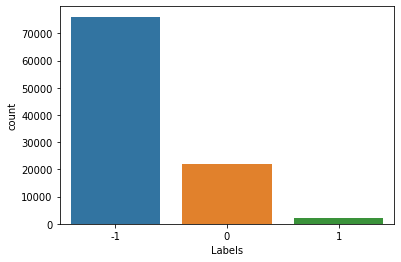

In [78]:
sns.countplot(x='Labels',data=df)

In [186]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("make nerve in neck")

if(doc[0].pos_ == "VERB" and doc[0].text == doc[0].lemma_):
    print(doc[0].text)

make
